In [1]:
import datetime

from utils.data_generator import *
from utils.util import *
from matplotlib import pyplot as plt
from fairness_methods.methods import FairnessMethods
from models.basic_mf_model import BasicMF
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## Real Data Preparation

In [2]:
ml_data = generate_real_data()
ml_data

,user_id,movie_id,rating,timestamp,Action,Crime,Musical,Romance,Sci-Fi,gender,age,occupation,zip
0,1,661,3,978302109,0,0,1,0,0,F,1,10,48067
1,1,914,3,978301968,0,0,1,1,0,F,1,10,48067
2,1,1197,3,978302268,1,0,0,1,0,F,1,10,48067
3,1,1287,5,978302039,1,0,0,0,0,F,1,10,48067
4,1,594,4,978302268,0,0,1,0,0,F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487930,6040,2021,3,956716374,0,0,0,0,1,M,25,6,11106
487931,6040,2028,5,956704519,1,0,0,0,0,M,25,6,11106
487932,6040,1089,4,956704996,0,1,0,0,0,M,25,6,11106
487933,6040,1094,5,956704887,0,0,0,1,0,M,25,6,11106


**get list of user ids by gender to relevant indexes**

In [10]:
user_id_to_index = {user_id: index for (index, user_id) in enumerate(ml_data['user_id'].unique())}
user_gender = {}
for row in ml_data[["user_id", "gender"]].to_dict('records'):
    user_gender.setdefault(row['gender'], []).append(user_id_to_index[row['user_id']])
user_gender["F"] = list(set(user_gender["F"]))
user_gender["M"] = list(set(user_gender["M"]))

**rating matrix analysis**

In [4]:
ratings = pd.pivot_table(ml_data, values='rating', index='user_id', columns='movie_id')
ratings.fillna(0, inplace=True)

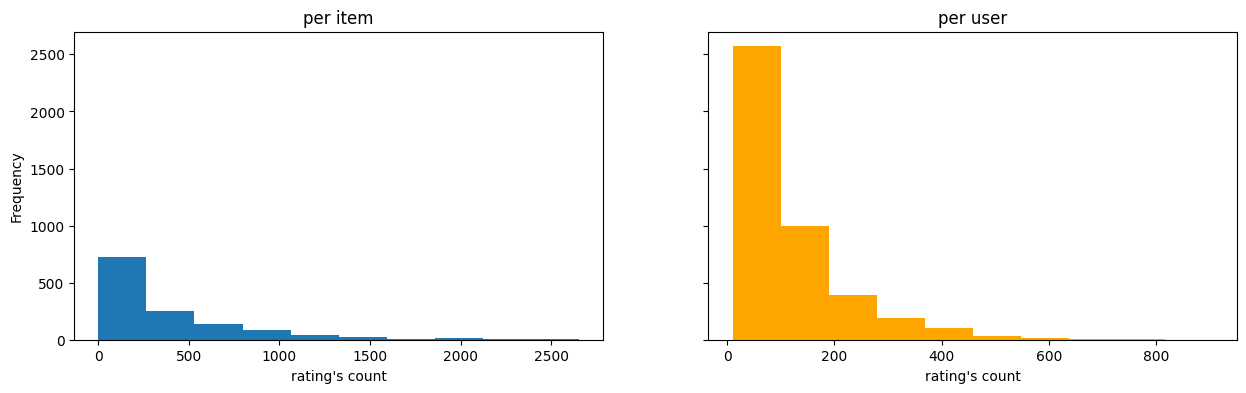

In [5]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.astype(bool).sum(axis=0).plot.hist(ax=ax[0])
ratings.astype(bool).sum(axis=1).plot.hist(ax=ax[1], color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('rating\'s count')
ax[1].set_xlabel('rating\'s count');

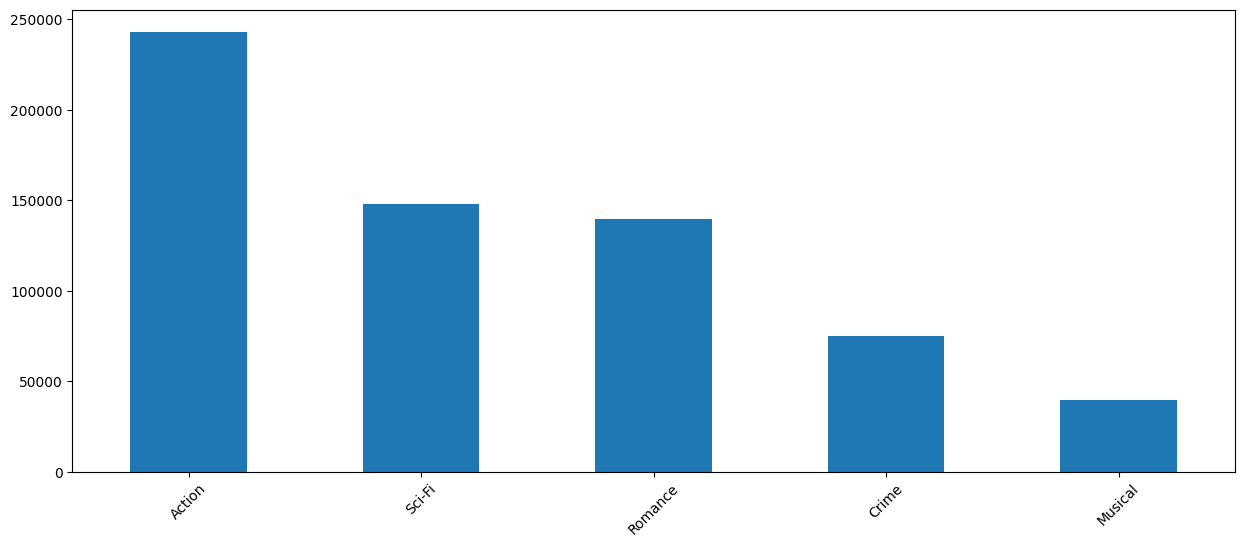

In [6]:
plt.figure(figsize=(15,6))
ml_data[GENRES].sum().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=45)
plt.show();

## Training Basic Matrix Factorization Model and calculate fairness matrices

In [7]:
results = []
for test_id in range(1, NUMBER_OF_TESTS + 1):
    print(f"start run MF model number {test_id}")
    start_time = datetime.datetime.now()
    train, test = train_test_split(ml_data, test_size=0.2, shuffle=True, stratify=ml_data[['user_id']])
    train_set = pd.pivot_table(train, values='rating', index='user_id', columns='movie_id')
    train_set.fillna(0, inplace=True)
    test_set = pd.pivot_table(train, values='rating', index='user_id', columns='movie_id')
    model_mf = BasicMF(train_set.values, n_factors=5, only_bias=False)
    model_mf.fit(n_iterations=10, verbose=False, regularization=0.01, convergence=1e-100, learning_rate=0.1)
    predictions = model_mf.predict()
    predictions[predictions == 0] = 'nan'
    results.append({"val_score": FairnessMethods().calculate_val_score(predictions, test_set.to_numpy(),
                                                                       np.array(user_gender["M"]),
                                                                       np.array(user_gender["F"]),
                                                                       len(train_set.columns)),
                    "abs_score": FairnessMethods().calculate_abs_score(predictions, test_set.to_numpy(),
                                                                       np.array(user_gender["M"]),
                                                                       np.array(user_gender["F"]),
                                                                       len(train_set.columns)),
                    "under_score": FairnessMethods().calculate_under_score(predictions, test_set.to_numpy(),
                                                                           np.array(user_gender["M"]),
                                                                           np.array(user_gender["F"]),
                                                                           len(train_set.columns)),
                    "over_score": FairnessMethods().calculate_over_score(predictions, test_set.to_numpy(),
                                                                         np.array(user_gender["M"]),
                                                                         np.array(user_gender["F"]),
                                                                         len(train_set.columns))})
    end_time = datetime.datetime.now()
    print(f"finished run MF model number {test_id} after {(end_time - start_time).seconds} seconds")

start run MF model number 1
finished run MF model number 1 after 210 seconds
start run MF model number 2
finished run MF model number 2 after 212 seconds
start run MF model number 3
finished run MF model number 3 after 208 seconds
start run MF model number 4
finished run MF model number 4 after 181 seconds
start run MF model number 5
finished run MF model number 5 after 181 seconds


In [8]:
pd.DataFrame(results).describe()

,val_score,abs_score,under_score,over_score
count,5.000000,5.000000,5.000000,5.000000
mean,0.266262,0.188551,0.125578,0.140684
std,0.006731,0.004524,0.005474,0.003706
min,0.260855,0.182739,0.119897,0.136047
25%,0.262948,0.187130,0.122320,0.138535
50%,0.264622,0.188346,0.124582,0.140040
75%,0.264938,0.189240,0.126901,0.143755
max,0.277948,0.195300,0.134192,0.145041


<AxesSubplot: >

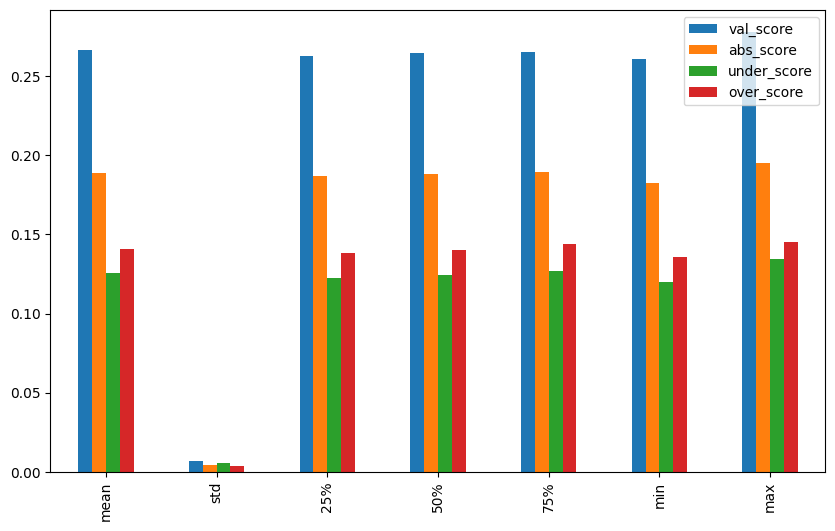

In [9]:
pd.DataFrame(results).describe().loc[["mean", "std", "25%", "50%", "75%", "min", "max"]].plot(kind='bar', figsize=(10,6), legend=True)